# Example: 2D Koopman - Part 3/3

- Author: Dr. Daning Huang
- Date: 08/15/2025
- Edit: 10/14/2025

As the third part of this example, we show two things:

- A "linear trainer" that is equivalent to the standard least-squares fitting for a Koopman model.
- Using linear trainer inside another trainer, e.g., NODE or WeakForm, to accelerate the convergence.

## Preparation

As usual, a few imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from dymad.io import load_model
from dymad.models import DKBF
from dymad.training import NODETrainer, LinearTrainer   # Note the new trainer here
from dymad.utils import plot_summary, plot_trajectory, TrajectorySampler

We already have data from Part 1, so no data generation here. The config file `kp_model.yaml` is the same, too.

Next, the specifications for modeling.  We use a concatenation autoencoder, so the reconstruction loss is always zero.

In [2]:
mdl_kb = {
    "name" : 'kp_model',
    "encoder_layers" : 2,
    "decoder_layers" : 2,
    "latent_dimension" : 32,
    "koopman_dimension" : 8,
    "autoencoder_type": "cat",
    "activation" : "tanh",
    "weight_init" : "xavier_uniform"}

## Linear Trainer

The linear trainer only updates the linear part of the model; in the KBF case, this means the system matrices.  In this process, the weights in the autoencoder are not updated.  The linear components are computed by a least squares problem, standard for Koopman learning:

$$
\min_A \|Z_{n+1}-AZ_n\|
$$
where $Z$ is the collection of encoded states, and $n$ and $n+1$ refer to the current and next steps.

The simplest setup is the following, where the `ls_update` option chooses a `full` least squares solution, i.e.,

$$
A=Z_{n+1}Z_n^+
$$
where $\Box^+$ means pseudo-inverse.

In [3]:
trn_ln1 = {
    "n_epochs": 1,
    "save_interval": 1,
    "load_checkpoint": False,
    "ls_update": {
        "method": "full"}
    }

We can choose also `truncated` solution, where `params` specifies the rank

$$
A=Z_{n+1}V_r\Sigma_r^{-1} U_r^H
$$
where $Z_n\approx U_r\Sigma_rV_r^H$ is an $r$th-rank truncated SVD.  In the option below, $r=4$.

In [4]:
trn_ln2 = {
    "n_epochs": 1,
    "save_interval": 1,
    "load_checkpoint": False,
    "ls_update": {
        "method": "truncated",
        "params": 4}
    }

Next we run the training.  The current implementation collects all data samples and perform least-squares once, so each training only needs one iteration.

> Ignore the possible warnings, which is due to incompatibility of Numpy and Apple M4 chip.

In [5]:
trn_opts = [trn_ln1, trn_ln2]
config_path = 'kp_model.yaml'

IDX = [0, 1]

for i in IDX:
    opt = {"model": mdl_kb, "training": trn_opts[i]}
    opt["model"]["name"] = f"kp_ln{i+1}"
    trainer = NODETrainer(config_path, DKBF, config_mod=opt)
    trainer.train()

/Users/daninghuang/Repos/dymad-dev/src/dymad/training/ls_update.py:285: RuntimeWarning: divide by zero encountered in matmul
  avg_epoch_loss = np.linalg.norm(A @ W - b) / A.shape[0]
/Users/daninghuang/Repos/dymad-dev/src/dymad/training/ls_update.py:285: RuntimeWarning: overflow encountered in matmul
  avg_epoch_loss = np.linalg.norm(A @ W - b) / A.shape[0]
/Users/daninghuang/Repos/dymad-dev/src/dymad/training/ls_update.py:285: RuntimeWarning: invalid value encountered in matmul
  avg_epoch_loss = np.linalg.norm(A @ W - b) / A.shape[0]
/Users/daninghuang/Repos/dymad-dev/src/dymad/numerics/linalg.py:160: RuntimeWarning: divide by zero encountered in matmul
  _B = (_Ur.conj().T @ B) / _Sr.reshape(-1, 1)
/Users/daninghuang/Repos/dymad-dev/src/dymad/numerics/linalg.py:160: RuntimeWarning: overflow encountered in matmul
  _B = (_Ur.conj().T @ B) / _Sr.reshape(-1, 1)
/Users/daninghuang/Repos/dymad-dev/src/dymad/numerics/linalg.py:160: RuntimeWarning: invalid value encountered in matmul
  _B 

Next, test out the models.  Neither of them do well, because the autoencoder is not trained yet.  But the least squares do get the model behave roughly like the truth.

In [6]:
N = 301
t_grid = np.linspace(0, 6, N)

mu = -0.5
lm = -3
def f(t, x):
    _d = np.array([mu*x[0], lm*(x[1]-x[0]**2)])
    return _d

sampler = TrajectorySampler(f, config='kp_data.yaml')
ts, xs, ys = sampler.sample(t_grid, batch=1)
x_data = xs[0]
t_data = ts[0]

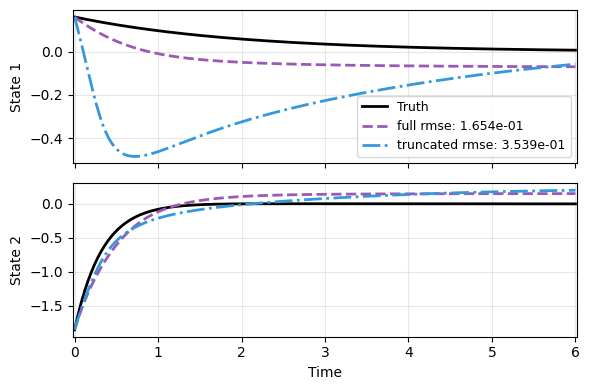

In [7]:
res = [x_data]
for i in IDX:
    mdl = f"kp_ln{i+1}"
    _, prd_func = load_model(DKBF, f'{mdl}.pt')
    with torch.no_grad():
        pred = prd_func(x_data, t_data)
    res.append(pred)

labels = ['full', 'truncated']
plot_trajectory(
    np.array(res), t_data, "KP",
    labels=['Truth'] + labels, ifclose=False);

## Linear-Accelerated Training

The previous results motivate us to take a mixed approach: use linear trainer to update the linear part, and let a regular trainer, e.g., NODE, to update the full model.  Next, let's try this out.

Below we first define a baseline, that uses pure NODE.

In [8]:
trn_ln3 = {
    "n_epochs": 1500,
    "save_interval": 20,
    "load_checkpoint": False,
    "learning_rate": 5e-3,
    "decay_rate": 0.999,
    "sweep_epoch_step": 500,
    "sweep_lengths": [2, 4, 6],
    "chop_mode": "unfold",
    "chop_step": 0.5,
}

The other is the same setup, but with a least squares update.  We specify the update to occur every 100 epochs for 3 times.  The update starts right before the first epoch.

In [9]:
trn_ln4 = {
    "ls_update": {
        "method": "full",
        "interval": 100,
        "times": 3}
}
trn_ln4.update(trn_ln3)

The training...

In [10]:
trn_opts = [trn_ln1, trn_ln2, trn_ln3, trn_ln4]
IDX = [2, 3]

for i in IDX:
    opt = {"model": mdl_kb, "training": trn_opts[i]}
    opt["model"]["name"] = f"kp_ln{i+1}"
    trainer = NODETrainer(config_path, DKBF, config_mod=opt)
    trainer.train()

The training would take some time, and here we check the convergence.

The definitions of losses are the same, and hence comparable.  Clearly the LS update significantly helps with convergence, where the second case started with a loss of over two-order-of-magnitude lower.

nd3 Epoch time: 0.024616854985555013
nd4 Epoch time: 0.022233674526214598


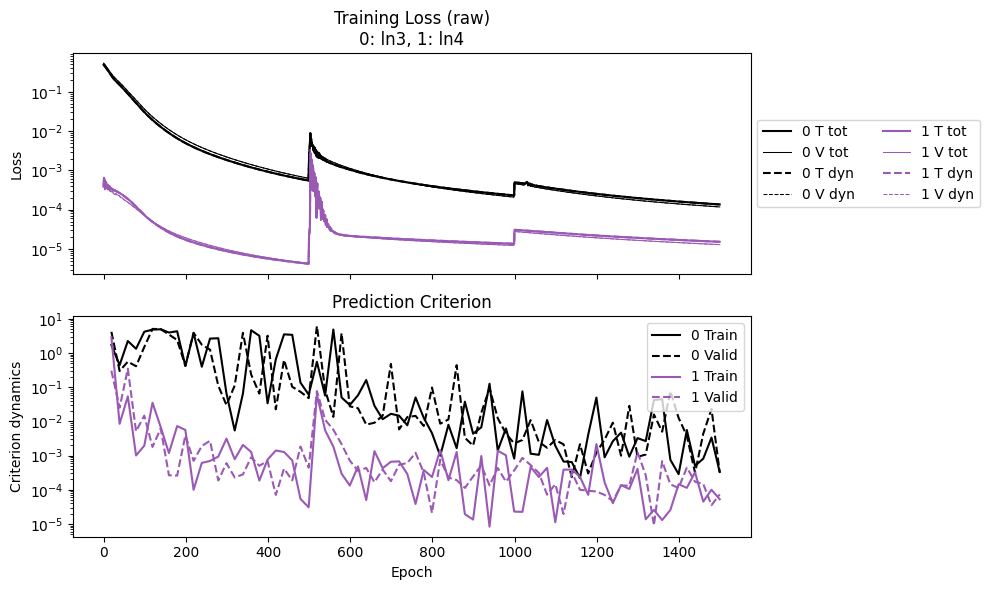

In [11]:
IDX = [2, 3]
labels = [f"ln{i+1}" for i in IDX]
npz_files = [f'kp_{l}' for l in labels]
npzs = plot_summary(npz_files, labels=labels, ifscl=False, ifclose=False)
for j, i in enumerate(IDX):
    print(f"nd{i+1} Epoch time:", npzs[j]['avg_epoch_time'])

Not surprisingly, the training accelerated by the least squares produces a much better prediction.

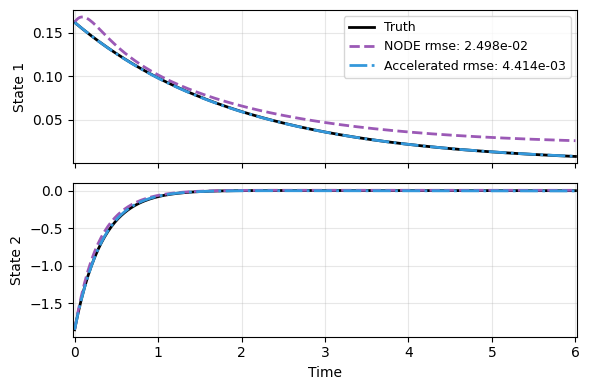

In [12]:
res = [x_data]
for i in IDX:
    mdl = f"kp_ln{i+1}"
    _, prd_func = load_model(DKBF, f'{mdl}.pt')
    with torch.no_grad():
        pred = prd_func(x_data, t_data)
    res.append(pred)

labels = ['NODE', 'Accelerated']
plot_trajectory(
    np.array(res), t_data, "KP",
    labels=['Truth'] + labels, ifclose=False);